# 30秒のCMから作成されたdtwよりマッピング

In [1]:
import os
import h5py
import networkx as nx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

/home/inagaki/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#被験者間の距離を算出
def matching_distance(matrix_1, matrix_2):
    #print('No.1 adjacency matrix shape is', matrix_1.shape)
    #print('No.2 adjacency matrix shape is', matrix_2.shape)
    return np.sum(np.abs(matrix_1 - matrix_2))/2

In [7]:
DATA_DIR = '/home/inagaki/data/'

os.chdir(DATA_DIR + "dtw30")
!ls

0101.hdf  0105.hdf  0109.hdf  0113.hdf	0117.hdf  0121.hdf  0125.hdf
0102.hdf  0106.hdf  0110.hdf  0114.hdf	0118.hdf  0122.hdf  0126.hdf
0103.hdf  0107.hdf  0111.hdf  0115.hdf	0119.hdf  0123.hdf  0127.hdf
0104.hdf  0108.hdf  0112.hdf  0116.hdf	0120.hdf  0124.hdf


In [8]:
matrix_list = []
for i in range(1,28):
    h5file = h5py.File("01" + "{0:02d}".format(i) + ".hdf","r")
    matrix = h5file[list(h5file.keys())[0]].value
    matrix = matrix[:120,:120] # train: 140, test: 20 のうち train だけを使う
    matrix_list.append(matrix)
print("There are", len(matrix_list), "people.")
matrix_list[0].shape

There are 27 people.


(120, 120)

In [9]:
distance_list = []
for i in matrix_list:
    for j in matrix_list:
        distance_list.append(matching_distance(i,j))

In [10]:
distance_matrix = np.reshape(np.array(distance_list), (27,27))

writepath = DATA_DIR + 'usermap30.hdf'
with h5py.File(writepath, 'w') as outfile:
    outfile.create_dataset('adjacency_matrix', data=distance_matrix)

In [11]:
max_distance = distance_matrix.max()
max_distance

185803.6496277295

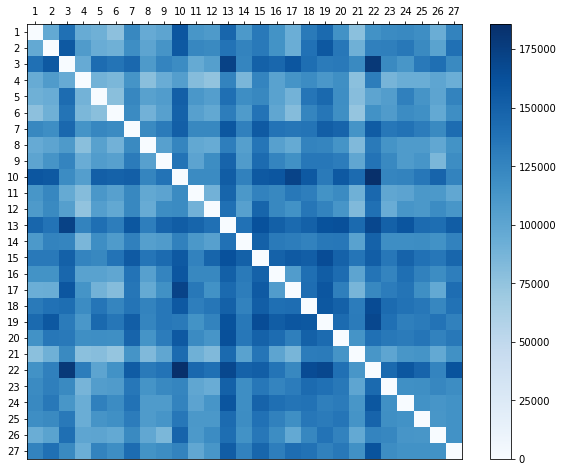

In [15]:
#距離をそのまま表した行列
person_label = [i for i in range(1,28)]
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(distance_matrix, vmin=0, vmax=max_distance, cmap=plt.cm.Blues)
ax.set_xticks(np.arange(distance_matrix.shape[0]), minor=False)
ax.set_yticks(np.arange(distance_matrix.shape[1]), minor=False)
ax.xaxis.tick_top()
ax.set_xticklabels(person_label, minor=False)
ax.set_yticklabels(person_label, minor=False)
fig.colorbar(im)
plt.show()

In [18]:
normal_distance_matrix = np.reshape(np.array([i/(120*120) for i in distance_list]), (27,27))
#np.sort(np.array([i/245169.30523971 for i in distance_list]))

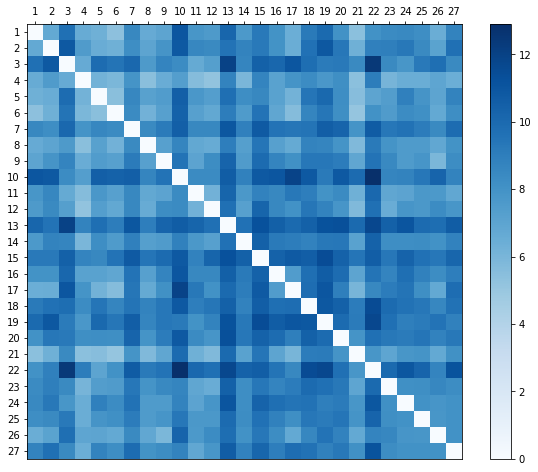

In [20]:
#距離を正規化して表した行列
person_label = [i for i in range(1,28)]
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(normal_distance_matrix, cmap=plt.cm.Blues)
ax.set_xticks(np.arange(normal_distance_matrix.shape[0]), minor=False)
ax.set_yticks(np.arange(normal_distance_matrix.shape[1]), minor=False)
ax.xaxis.tick_top()
ax.set_xticklabels(person_label, minor=False)
ax.set_yticklabels(person_label, minor=False)
fig.colorbar(im)
plt.show()

In [21]:
# new_distance_list = [0 if i >= 2500000 else i for i in distance_list]
# renew_distance_list = [i if i == 0.0 else 10000000000/i for i in new_distance_list]
renew_distance_list = [i if i == 0.0 else 10000000000/i for i in distance_list]
new_distance_matrix = np.reshape(np.array(renew_distance_list), (27,27))
new_G = nx.from_numpy_matrix(new_distance_matrix)

In [22]:
person_G = nx.Graph()
for i in list(new_G.edges(data="weight")):
    person_G.add_edge(i[0]+1, i[1]+1, weight=i[2])

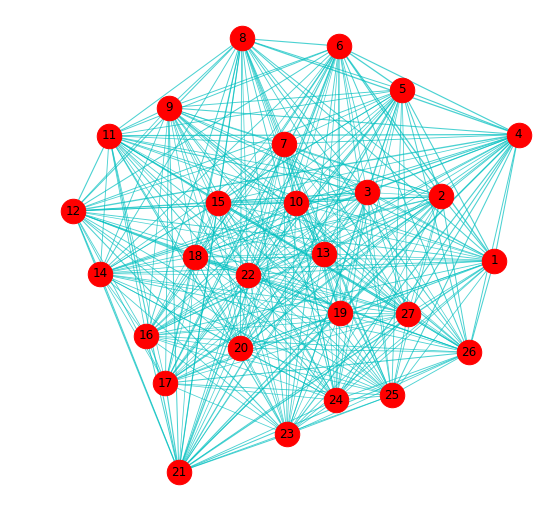

In [38]:
#距離の逆数を重みとしたネットワーク
person_pos = nx.kamada_kawai_layout(person_G)
plt.figure(figsize=(9, 9))
nx.draw_networkx_nodes(person_G, person_pos, node_size=600)
nx.draw_networkx_labels(person_G, person_pos, fontsize=14)
edge_width = [ d['weight']*0.00001 for (u,v,d) in person_G.edges(data=True)]
nx.draw_networkx_edges(person_G, person_pos, alpha=0.7, edge_color='C', width=edge_width)
plt.axis('off')
plt.show()

# コンテンツ間のネットワーク(27人分)

In [24]:
#上からnノード分抽出
n_node = 20
n_node_matrix_list = []
for i in matrix_list:
    n_node_list = np.array(i[0:n_node, 0:n_node]).flatten()
    n_node_matrix_list.append(np.reshape(np.array([i if i == 0.0 else 1000/i for i in n_node_list]), (20,20)))

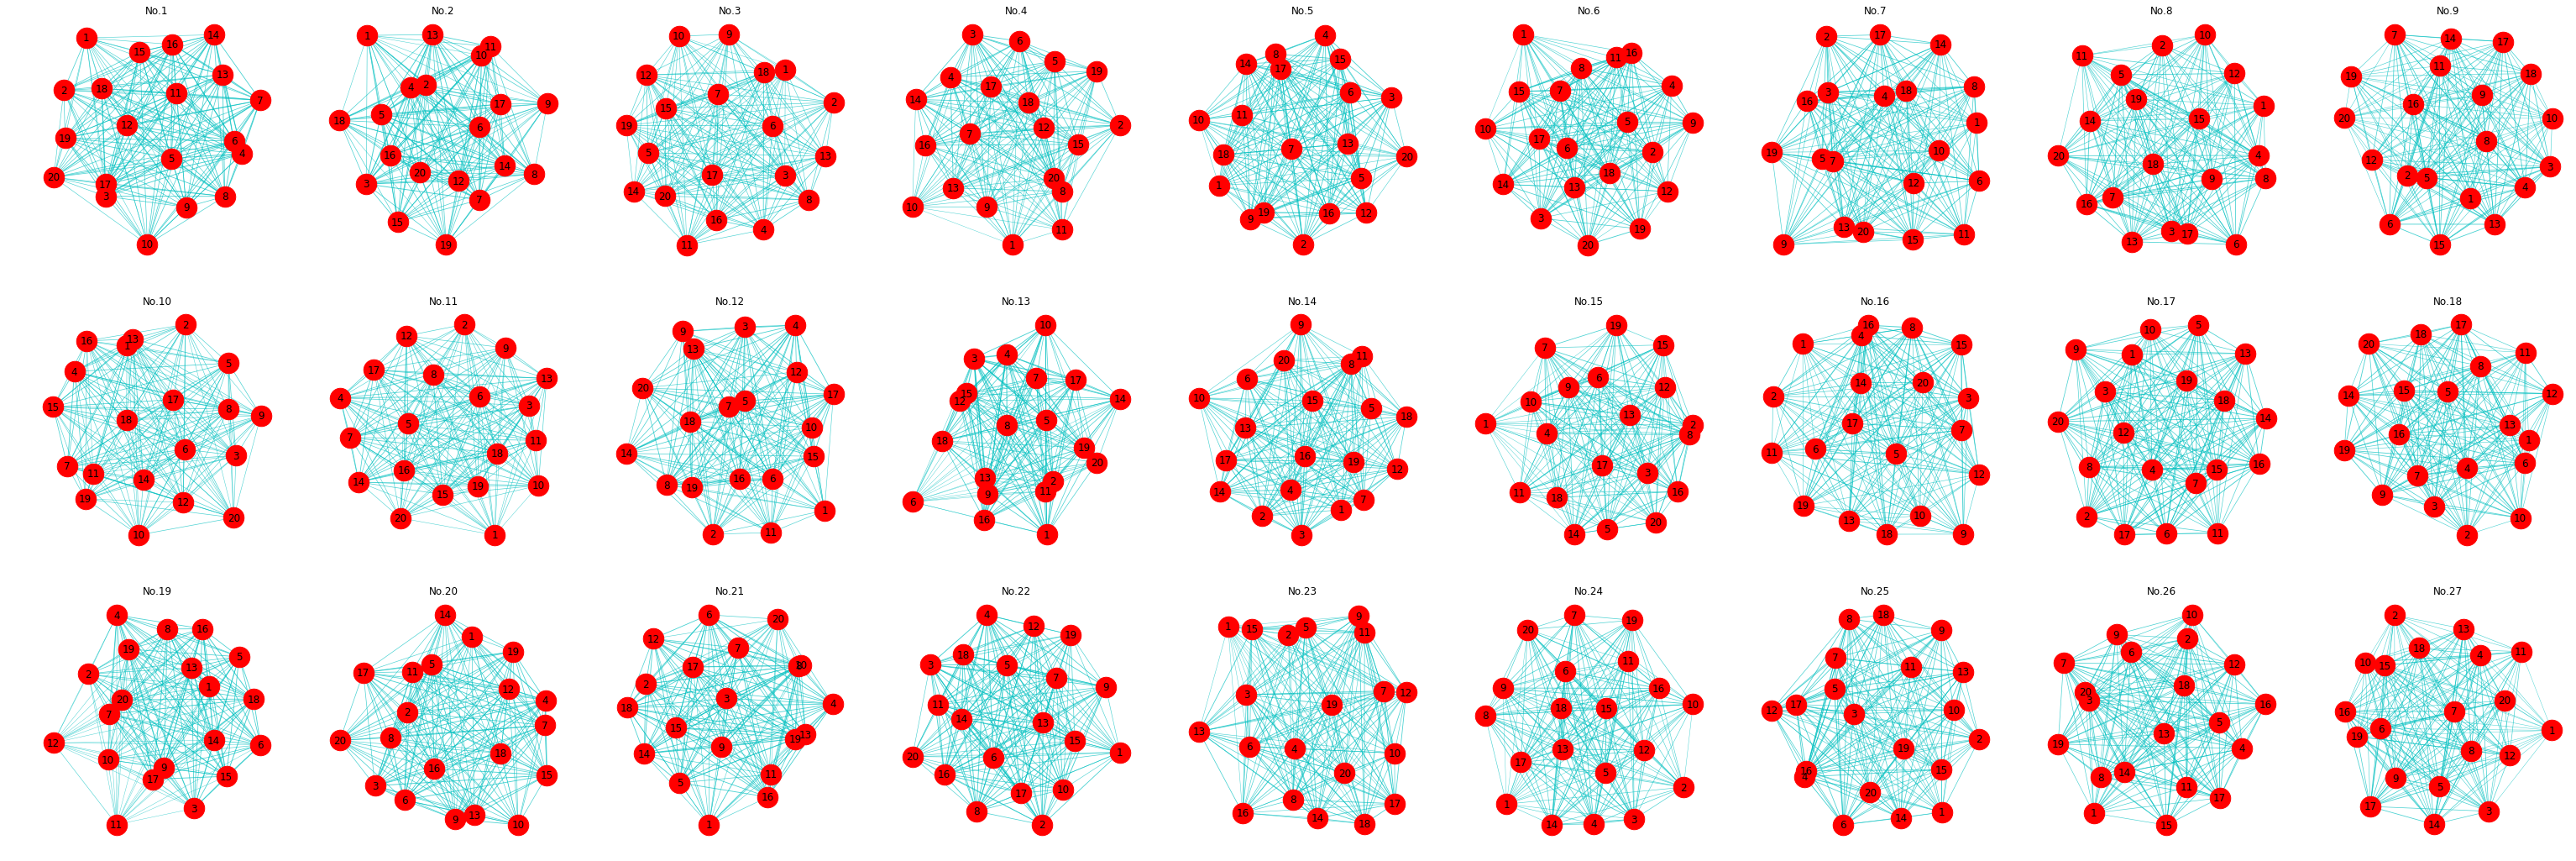

In [25]:
plt.figure(figsize=(54, 18))
for i in range(len(n_node_matrix_list)):
    new_G = nx.from_numpy_matrix(n_node_matrix_list[i])
    content_G = nx.Graph()
    for j in list(new_G.edges(data="weight")):
        content_G.add_edge(j[0]+1, j[1]+1, weight=j[2])
    content_pos = nx.spring_layout(content_G, k = 0.07)
    plt.subplot(3, 9, i+1)
    nx.draw_networkx_nodes(content_G, content_pos, node_size=600)
    nx.draw_networkx_labels(content_G, content_pos, fontsize=14)
    edge_width = [ d['weight']*0.1 for (u,v,d) in content_G.edges(data=True)]
    nx.draw_networkx_edges(content_G, content_pos, alpha=0.7, edge_color='C', width=edge_width)
    plt.axis('off')
    plt.title("No." + str(i + 1))
plt.show()

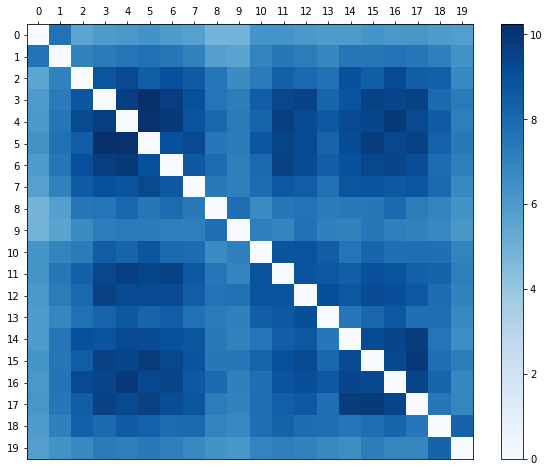

In [26]:
#被験者ID:01の20コンテンツにおけるdtwのスコア**の逆数**
content_label = [i for i in range(0,n_node)]
fig, ax = plt.subplots(figsize=(10, 8))
heatmap = ax.pcolor(n_node_matrix_list[0], cmap=plt.cm.Blues)
ax.set_xticks(np.arange(n_node_matrix_list[0].shape[0]) + 0.5, minor=False)
ax.set_yticks(np.arange(n_node_matrix_list[0].shape[1]) + 0.5, minor=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_xticklabels(content_label, minor=False)
ax.set_yticklabels(content_label, minor=False)
fig.colorbar(heatmap, ax=ax)
plt.show()

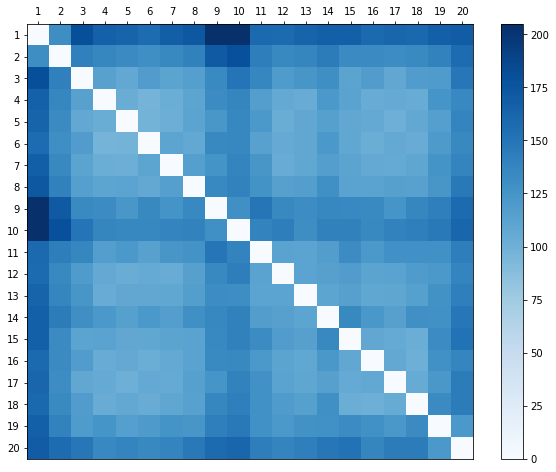

In [27]:
#被験者ID:01の20コンテンツにおけるdtwの距離
mat = matrix_list[0][:n_node, :n_node]
content_label = [i for i in range(1,n_node+1)]
fig, ax = plt.subplots(figsize=(10, 8))
heatmap = ax.pcolor(mat, cmap=plt.cm.Blues)
ax.set_xticks(np.arange(mat.shape[0]) + 0.5, minor=False)
ax.set_yticks(np.arange(mat.shape[1]) + 0.5, minor=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_xticklabels(content_label, minor=False)
ax.set_yticklabels(content_label, minor=False)
fig.colorbar(heatmap, ax=ax)
plt.show()

# 15秒と30秒で比較

In [29]:
os.chdir("/home/inagaki/data/dtw15")
!ls

0101.hdf  0105.hdf  0109.hdf  0113.hdf	0117.hdf  0121.hdf  0125.hdf
0102.hdf  0106.hdf  0110.hdf  0114.hdf	0118.hdf  0122.hdf  0126.hdf
0103.hdf  0107.hdf  0111.hdf  0115.hdf	0119.hdf  0123.hdf  0127.hdf
0104.hdf  0108.hdf  0112.hdf  0116.hdf	0120.hdf  0124.hdf


In [30]:
matrix_list = []
for i in range(1,28):
    h5file = h5py.File("01" + "{0:02d}".format(i) + ".hdf","r")
    matrix = h5file[list(h5file.keys())[0]].value
    matrix = matrix[:240,:240] # train: 240, test: 40 のうち train だけを使う
    matrix_list.append(matrix)
print("There are", len(matrix_list), "people.")
matrix_list[0].shape

There are 27 people.


(240, 240)

In [31]:
distance_list_15 = []
for i in matrix_list:
    for j in matrix_list:
        distance_list_15.append(matching_distance(i,j))

In [32]:
from sklearn.metrics import mean_squared_error, r2_score

In [35]:
distance_list_15sec = np.array([i/(240*240) for i in distance_list_15])
distance_list_30sec = np.array([i/(120*120) for i in distance_list])

In [36]:
r2_score(distance_list_15sec, distance_list_30sec, multioutput='variance_weighted')

0.7913927713045986

# 指標ごとのスコア取得

In [24]:
content_G_list = []
for i in matrix_list:
    content_G_list.append(nx.from_numpy_matrix(i))

In [25]:
#平均距離とクラスタ係数のスコアとpagerankのスコアの取得
average_length_list = []
average_clustering_list = []
for i in content_G_list:
    average_length_list.append(nx.average_shortest_path_length(i))
    average_clustering_list.append(nx.average_clustering(i))
pagerank_list = [b for a, b in sorted(nx.pagerank(person_G).items(), key=lambda x: x[0])]

# 距離の近い上位10ペアの抽出

In [40]:
distance_label_G = nx.from_numpy_matrix(distance_matrix)
distance_G = nx.Graph()
for i in list(distance_label_G.edges(data="weight")):
    distance_G.add_edge(i[0]+1, i[1]+1, weight=i[2])

In [41]:
ranking = 1 
for a, b, c in sorted(list(distance_G.edges(data="weight")), key=lambda x: x[2]):
    print("No." + str(ranking) + ": " + str(a) + " and " + str(b) + ": " + str(c))
    ranking += 1
    if ranking == 11:
        break

No.1: 6 and 21: 73711.6418021525
No.2: 4 and 12: 75054.30581423399
No.3: 1 and 6: 77640.03371732331
No.4: 1 and 21: 78021.07874461243
No.5: 4 and 21: 78141.65208964887
No.6: 5 and 6: 78625.77960236793
No.7: 4 and 8: 78846.11447672389
No.8: 5 and 21: 79853.18783106186
No.9: 6 and 17: 81054.07346250603
No.10: 4 and 11: 81208.09505692455


In [43]:
for i in range(0,10):
    a,b,c = sorted(list(distance_G.edges(data="weight")), key=lambda x: x[2])[i]
    print("No." + str( i+1) + " : dictance = " + str(c))
    print("Node : " + str(a) + " and " + str(b))
    print("length : " + str(average_length_list[a-1]) + " and " + str(average_length_list[b-1]))
    print("cluster : " + str(average_clustering_list[a-1]) + " and " + str(average_clustering_list[b-1]))
    print("pagerank :" + str(pagerank_list[a-1]) + " and " + str(pagerank_list[b-1]))
    print("====================================================")

No.1 : dictance = 73711.6418021525
Node : 6 and 21


NameError: name 'average_length_list' is not defined